In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

import sys
import os
dir_current = globals()['_dh'][0]
dir_repo = dir_current+'/../..'
dir_BinnedFit = dir_repo+"/BinnedFit"
dir_KLens = dir_repo+"/KLens"
dir_TNGcube = dir_repo+"/TNGcube"

sys.path.append(dir_KLens)
from KLtool import *

sys.path.append(dir_TNGcube)
from TNGcube import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
subhalo = pickle.load(open('../notebooks/subhalo_46.pkl', 'rb'))

In [3]:
pars = {}
pars['spinR'] = [0, 0, -1]
pars['sini'] = 1.0
pars['theta_int'] = 0. #np.pi/6.
pars['g1'] = 0.
pars['g2'] = 0.
pars['redshift'] = 0.35
pars['psfFWHM'] = 0.5
pars['slitAngles'] = [0., np.pi/2]

lambda_cen0 = ParametersTNG.lineLambda0['Halpha']
#lambda_cen0 = (lineLambda0['OIIa']+lineLambda0['OIIb'])/2.

pars['lambda_cen'] = (1+pars['redshift'])*lambda_cen0

In [4]:
pars['expTime'] = 15.*60.              # [unit: sec]
pars['area'] = 3.14 * (1000./2.)**2    # telescope area [unit: cm2]

pars['ref_SDSS_lineL'] = 1.*1e-17      # [unit: erg/s/Angstrom/cm2]    # * u.erg/u.second/u.Angstrom/u.cm**2

#fiber_SDSS = np.pi * 1.5**2.           # fiber size [unit: arcsec2]
#refSDSSspec = pars['ref_SDSS_lineL'] * u.erg/u.second/u.Angstrom/u.cm**2
#refSDSSspec = refSDSSspec.to(u.erg/u.second/u.nm/u.cm**2)
#print('reference SDSS fiber spec:', refSDSSspec)

#pars['lineflux'] = refSDSSspec.value / fiber_SDSS  # [unit: erg/s/cm2/nm/arcsec2]
#pars['lineflux']

In [5]:
mock = TNGmock(pars=pars, subhalo=subhalo)

In [6]:
R_spin = mock.spin_rotation(spin0=mock.subhalo.info['spin'], spinR=pars['spinR'])
R_sini = mock.sini_rotation(sini=pars['sini'])
R_pa = mock.PA_rotation(theta_int = pars['theta_int'])

Rtot = R_pa@R_sini@R_spin

mock.subhalo.rotation(R=Rtot)
mock.subhalo.shear(g1=pars['g1'], g2=pars['g2'])

In [7]:
massCube = mock.gen_massCube(ptlTypes=['gas','stars'], lineTypes=mock.line_species, subhalo=mock.subhalo)
specCube = mock.mass_to_light(massCube)
specCube.add_psf(psfFWHM=mock.Pars.fid['psfFWHM'], psf_g1=mock.Pars.fid['psf_g1'], psf_g2=mock.Pars.fid['psf_g2'])
specCube = mock.flux_renorm(specCube)
specCube = mock.add_sky_noise(specCube)

In [8]:
slitObj = SlitSpec(specCube, slitWidth=mock.Pars.fid['slitWidth'])
spectra = slitObj.get_spectra(slitAngles=mock.Pars.fid['slitAngles'])

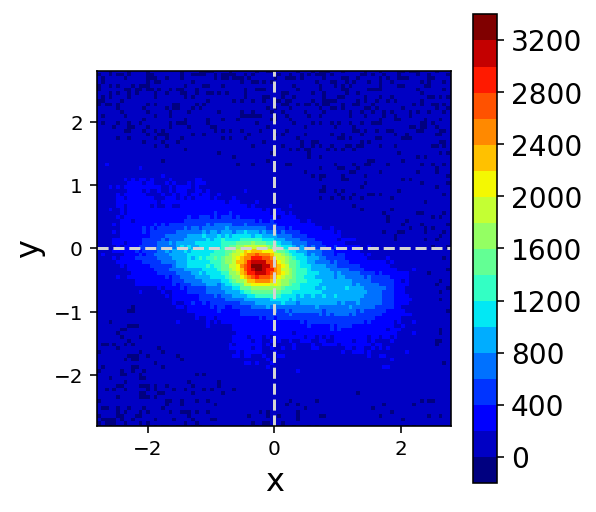

In [9]:
plot_image( np.sum(specCube.array, axis=2), spaceGrid=specCube.spaceGrid, xlim=[-2.8, 2.8])

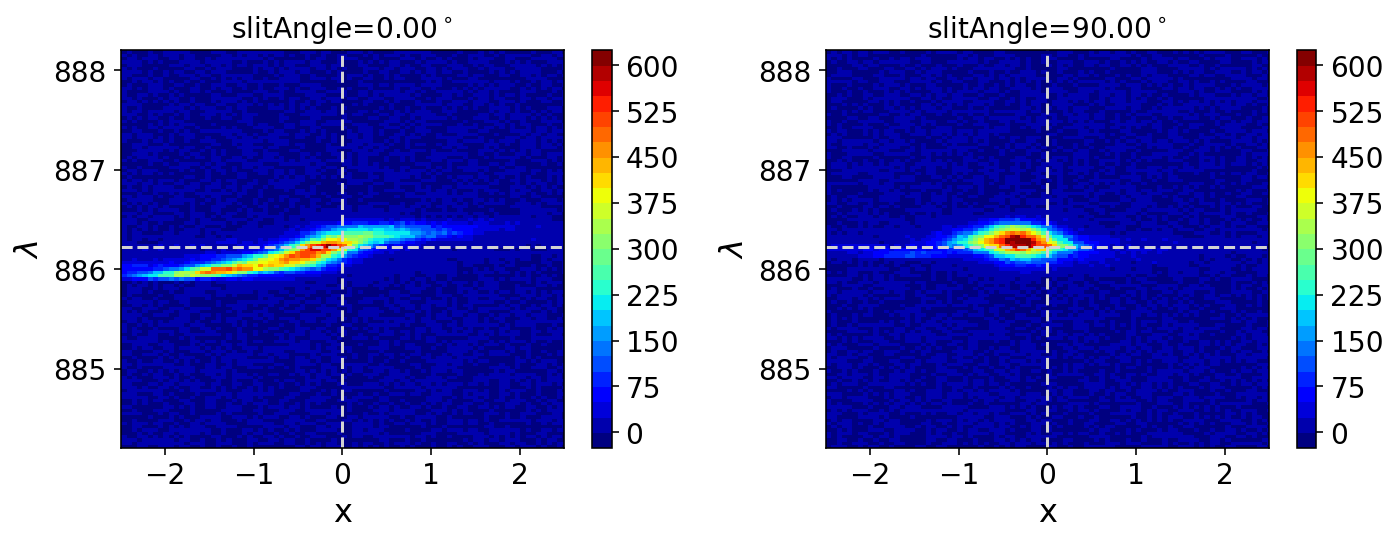

In [10]:
plot_specs(spectra, slitAngles=mock.Pars.fid['slitAngles'], spaceGrid=specCube.spaceGrid, lambdaGrid=specCube.lambdaGrid, xlim=[-2.5, 2.5])